# [映画レビューのテキスト分類](https://www.tensorflow.org/tutorials/keras/text_classification?hl=ja)

映画のレビューをそのテキストを使って肯定的か否定的かに分類する（二値分類あるいは2クラス分類という問題の例）。

Internet Movie Databaseから抽出した50,000件の映画レビューを含むIMDB datasetを利用。訓練用とテスト用にそれぞれ25,000件用意されている。肯定的なレビューと否定的なレビューが半々で存在する。

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import os

os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
print(tf.__version__)

2.0.0


In [2]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


tensorflowにパッケージ化されているIMDBデータセットは前処理済み。レビューが辞書中の特定の単語に対応する整数の配列に変換されている。`new_words=1000`は訓練データ中に出てくる単語のうち、最も頻繁に出現する10,000個を保持するためのもの。データサイズを管理可能にするため、稀にしか出現しない単語は破棄される。

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

整数を文字列にマッピングする辞書オブジェクトを検索するための関数

In [6]:
# dict() that maps words to integers
word_index = imdb.get_word_index()

# The first 3 indices are already fixed
word_index = {k: (v + 3) for k, v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

データの準備

データはNNに投入する前に、テンソルに変換する。
- method 1: one-hotエンコーディングと同じように、単語の出現を表す0と1のベクトルに変換（例：\[3, 5\]という配列は、インデックス3と5を除いてすべて0の10,000次元のベクトルになる）。この時、最初の層は浮動小数店のベクトルデータを扱うことができるDense層とする。
- method 2: 配列をパディングによって同じ長さに揃え、（サンプル数）*（長さの最大値）の形の整数テンソルにする。この時、最初の層はこの形式を扱うことができるEmbedding層とする。

ここではmethod 2を採用

In [8]:
# 長さを標準化する

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=256
)
test_data = keras.preprocessing.sequence.pad_sequences(
    test_data,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=256
)

In [9]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

モデルの構築

- 入力データ：単語インデックスの配列
- 出力：ラベル（0 or 1）

In [11]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


- Layer 1: `Embedding(input_dim, output_dim)`層。整数にエンコードされた語彙を受け取り、それぞれの単語インデックスに対応する埋め込みベクトルを検索する。埋め込みベクトルはモデルの訓練の中で学習される。ベクトル化のため、出力行列には次元が1追加される（Input shape: `(batch_size, input_length)`, Output shape: `(batch_size, input_length, output_dim)`）。
- Layer 2: `GlobalAveragePooling1D()`層。それぞれのサンプルについて、シーケンスの次元方向に平均値を求め、固定長のベクトルを返す。この結果、モデルは最も単純な形で可変長の入力を扱うことができる。Input shape: `(batch_size, steps, features)`, Output shape: `(batch_size, features)`
- Layer 3: `Dense(units)`層。16個のノードを持つ全結合層の隠れユニット。隠れユニットのノード数は、モデルが学習によって獲得する内部表現の自由度を決定する。多くの隠れユニットがある場合、または多くの層がある場合、モデルはより複雑な内部表現を学習することができる。一方で、計算量が多くなり、学習してほしくないパターンを学習してしまう可能性がある（過学習）。
- Layer 4: `Dense(units)`層。1個のノードを持つ全結合層。Sigmoid関数を利用することで、出力値は0から1の確率（あるいは確信度）で表される。

損失関数とオプティマイザ

今回の問題は二値分類問題であり、モデルの出力は確率であるため、損失関数には`binary_crossentropy`（二値のクロスエントロピー）関数を使用。`binary_crossentropy`は、確率分布の間の「距離」を測定する関数であるので、今回のような確率を扱う場合に適している。他には、`mean_squared_error`（平均二乗誤差）を使うこともできる。

In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

訓練を行う際に、モデルが見ていないデータ（検証データ：validation set）での正解率を検証する。元の訓練データから10000個のサンプルを取り出し、それらを利用する。

In [13]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

モデルの訓練

512個のサンプルからなるミニバッチを使って、40エポックモデルを訓練する。

In [14]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=1
)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 4s 270us/sample - loss: 0.6925 - accuracy: 0.5339 - val_loss: 0.6914 - val_accuracy: 0.5728
Epoch 2/40
15000/15000 [==============================] - 3s 220us/sample - loss: 0.6891 - accuracy: 0.6082 - val_loss: 0.6868 - val_accuracy: 0.7222
Epoch 3/40
15000/15000 [==============================] - 4s 239us/sample - loss: 0.6813 - accuracy: 0.7507 - val_loss: 0.6765 - val_accuracy: 0.7417
Epoch 4/40
15000/15000 [==============================] - 4s 250us/sample - loss: 0.6665 - accuracy: 0.7579 - val_loss: 0.6589 - val_accuracy: 0.7579
Epoch 5/40
15000/15000 [==============================] - 4s 247us/sample - loss: 0.6425 - accuracy: 0.7759 - val_loss: 0.6317 - val_accuracy: 0.7730
Epoch 6/40
15000/15000 [==============================] - 4s 261us/sample - loss: 0.6077 - accuracy: 0.7959 - val_loss: 0.5953 - val_accuracy: 0.7893
Epoch 7/40
15000/15000 [==========================

In [15]:
# evaluate the trained model

results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

25000/1 - 1s - loss: 0.3273 - accuracy: 0.8734
[0.32191541508197785, 0.8734]


正解率と損失の時系列グラフ

`model.fit()`は、訓練中に発生した全てのことを記録した辞書を含む`History`オブジェクトを返す。

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

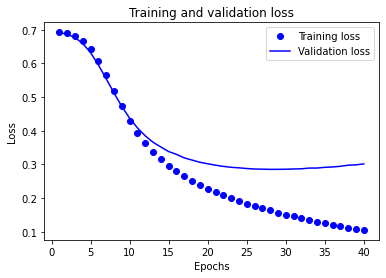

In [17]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

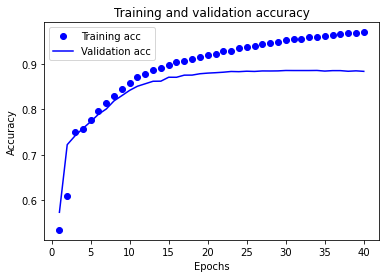

In [18]:
plt.clf()   # 図のクリア

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

上記のグラフでは、点が訓練時の損失と正解率を、実線が検証時の損失と正解率を表しています。

訓練時の損失がエポックごとに**減少**し、訓練時の正解率がエポックごとに**上昇**していることに気がつくはずです。繰り返すごとに指定された数値指標を最小化する勾配降下法を最適化に使用している場合に期待される動きです。

これは、検証時の損失と正解率には当てはまりません。20エポックを過ぎたあたりから、横ばいになっているようです。これが、過学習の一例です。モデルの性能が、訓練用データでは高い一方で、見たことの無いデータではそれほど高くないというものです。このポイントをすぎると、モデルが最適化しすぎて、訓練用データでは特徴的であるが、テスト用データには一般化できない内部表現を学習しています。

このケースの場合、20エポックを過ぎたあたりで訓練をやめることで、過学習を防止することが出来ます。後ほど、コールバックを使って、これを自動化する方法を紹介します。